In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
bhavikjikadara_fake_news_detection_path = kagglehub.dataset_download('bhavikjikadara/fake-news-detection')

print('Data source import complete.')


100%|██████████| 41.0M/41.0M [00:00<00:00, 87.8MB/s]

Extracting files...


Data source import complete.


In [2]:
!pip install keras-core --upgrade
!pip install -q keras-nlp
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 18.9 MB/s eta 0:00:00


# Import the Libararies

In [3]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
import keras_nlp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("KerasNLP version:", keras_nlp.__version__)

Using TensorFlow backend
TensorFlow version: 2.18.0
Keras version: 0.1.7
KerasNLP version: 0.18.1


# Load the data


In [5]:
from google.colab import files
uploaded = files.upload()


Saving fake.csv to fake.csv
Saving true.csv to true.csv


In [6]:
# Read the uploaded CSV files
import pandas as pd
import io
true = pd.read_csv(io.BytesIO(uploaded['true.csv']))
fake = pd.read_csv(io.BytesIO(uploaded['fake.csv']))

# Explore the dataset

<Axes: ylabel='count'>

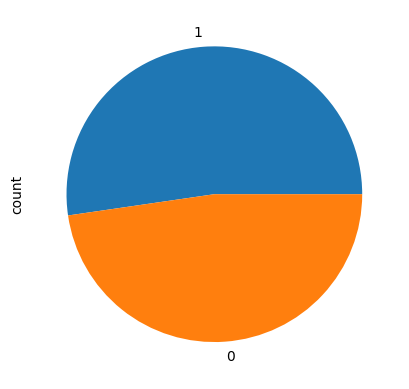

In [7]:
true['true_or_fake']=0
fake['true_or_fake']=1
df= pd.concat([fake, true], ignore_index=True)
df1 = df.sample(frac=1).reset_index(drop=True)
df1.true_or_fake.value_counts().plot(kind='pie')


we created a column for the labels as 1 represnt fake news and 0 represnt real news

# Create the model

In [8]:
import keras
from keras_nlp.models import DistilBertPreprocessor, DistilBertClassifier

SEQ_LENGTH = 512

# Preprocessing layer
preprocessor = DistilBertPreprocessor.from_preset(
    "distil_bert_base_en_uncased",
    sequence_length=SEQ_LENGTH,
)

# Classifier model
classifier = DistilBertClassifier.from_preset(
    "distil_bert_base_en_uncased",
    num_classes=2,
    activation=None,
    preprocessor=preprocessor,
)

# Set backbone to non-trainable
classifier.backbone.trainable = False

# Compile the model
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(5e-4),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

# Display the model summary
classifier.summary()


Preprocessor: "distil_bert_text_classifier_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)                   │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "distil_bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 592,130 (2.26 MB)

 Non-trainable params: 66,362,880 (253.15 MB)

In [9]:
# Split the dataset into train and test sets
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(df1["text"],
                                                    df1["true_or_fake"],
                                                    test_size=0.30,
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp,
                                                  y_temp,
                                                  test_size=0.30,
                                                  random_state=42)


In [10]:
import tensorflow as tf
print("GPU available:", tf.config.list_physical_devices('GPU'))


GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [11]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [12]:
import time

start_time = time.time()

classifier.fit(x=X_train,
               y=y_train,
               validation_data=(X_test, y_test),
               epochs=2,
               batch_size=64
              )

end_time = time.time()
print(f"Training took {end_time - start_time} seconds")


Epoch 1/2
344/344 ━━━━━━━━━━━━━━━━━━━━ 678s 2s/step - loss: 0.1991 - sparse_categorical_accuracy: 0.9287 - val_loss: 0.0476 - val_sparse_categorical_accuracy: 0.9838
Epoch 2/2
344/344 ━━━━━━━━━━━━━━━━━━━━ 589s 2s/step - loss: 0.0706 - sparse_categorical_accuracy: 0.9751 - val_loss: 0.0302 - val_sparse_categorical_accuracy: 0.9900
Training took 1267.5515031814575 seconds


In [13]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["true","fake"],
        cmap=plt.cm.Blues
    )
    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))
    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

In [14]:
y_pred_test = classifier.predict(X_test)

421/421 ━━━━━━━━━━━━━━━━━━━━ 216s 501ms/step


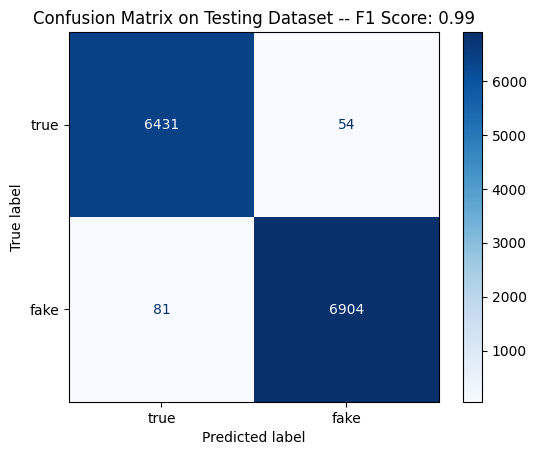

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
displayConfusionMatrix(y_test, y_pred_test,  "Testing")

In [16]:
y_pred_val = classifier.predict(X_val)

295/295 ━━━━━━━━━━━━━━━━━━━━ 150s 508ms/step


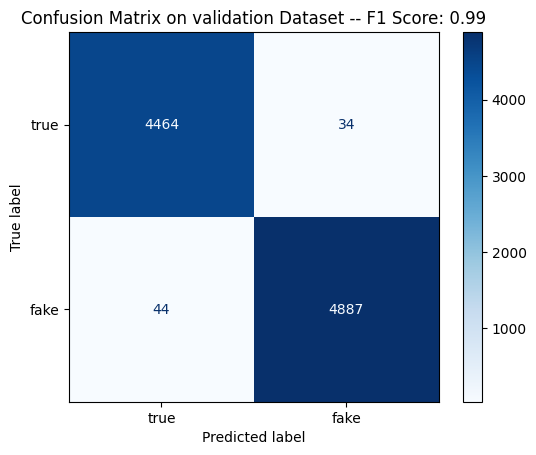

In [17]:
displayConfusionMatrix(y_val, y_pred_val,  "validation")

In [29]:
# Save the trained model in .h5 format
model_h5_path = '/content/fake_news_detector_model.h5'
classifier.save(model_h5_path)
print(f"Model saved at {model_h5_path}")


Model saved at /content/fake_news_detector_model.h5


In [30]:
from google.colab import files
import shutil

# Compress the saved model file into a zip
shutil.make_archive(model_h5_path, 'zip', '/content', 'fake_news_detector_model.h5')

# Provide the download link
files.download(model_h5_path + '.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Define the tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")

# Assuming you have your text data (let's say X_train) to fit the tokenizer
tokenizer.fit_on_texts(X_train)


In [35]:
import pickle

# Save tokenizer
with open('/content/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the vectorizer (example using TF-IDF)
vectorizer = TfidfVectorizer(max_features=5000)

# Fit the vectorizer on your training data (X_train in this example)
vectorizer.fit(X_train)

# Save the vectorizer to a file
with open('/content/vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)


In [38]:
from google.colab import files

# Download the tokenizer.pkl file
files.download('/content/tokenizer.pkl')

# If you also need to save and download the vectorizer
with open('/content/vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

# Download the vectorizer.pkl file
files.download('/content/vectorizer.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>